In [1]:
%matplotlib inline

from lib import plot
from lib.classification_report import ClassificationReport
from lib.neural_networks import NeuralNetwork
from lib.dataset import get_orl_dataset
from lib.pca import PCA
from lib.plot import plot_eigenface
from lib.util import scale, prepare_labels

import logging

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from numpy import copy, mean, bincount, sum

import os

import cPickle as pickle

from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

import sys

from time import time

/Users/tranl01/anaconda/envs/learn/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Show logs during runtime 
# (does not work with ipython notebook, 
#but for normal python interpreter)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

# Dataset
- Get "Labeled Faces in the Wild" (LFW) people dataset
- Data will be downloaded, if not available locally, and loaded as numpy array
- Print out information about dataset

In [3]:
orl = get_orl_dataset()
orl.summarize()
X = orl.X
y = orl.y
n_samples = orl.n_samples

Size of ORL dataset:
 - Number of samples: 400
 - Number of features: 10304
 - Number of classes: 40
 - Minimum number of faces per person: 10


In [34]:
# Splitting data set in training set and test set
X_train, X_test, y_train, y_test = orl.load_train_test_split()

# Eigenface algorithm

Explained variance: 0.860821434375


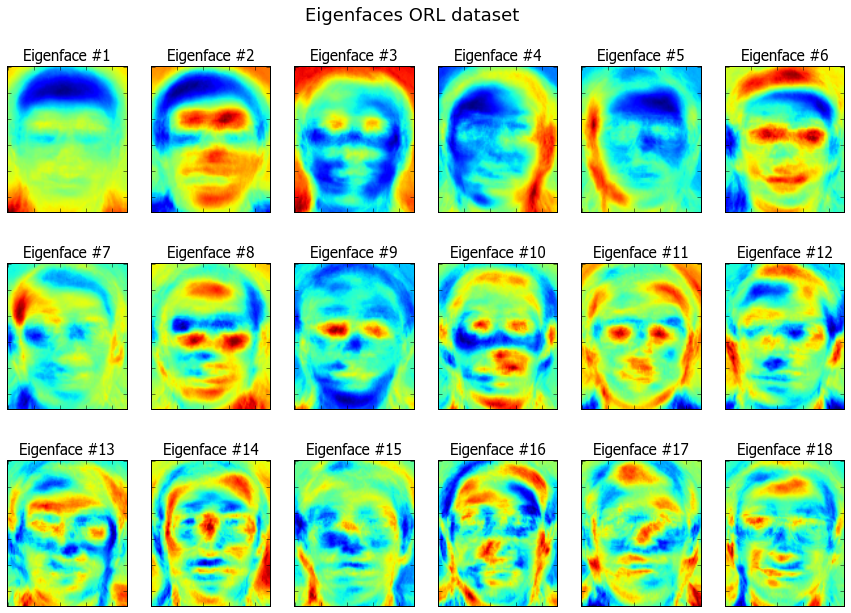

In [35]:
# Example of PCA
pca = PCA(X, n_components=75)
print "Explained variance: %s" % sum(pca.get_explained_variance_ratio())
components = pca.get_components()
mu = pca.get_mu()
Eigenfaces = []
for i in range(min(len(X), 18)):
    e = components[i,:].reshape(orl.h, orl.w)
    Eigenfaces.append(scale(e,0,255))
plot_eigenface(
    title="Eigenfaces ORL dataset", images=Eigenfaces, rows=3, cols=6,
    sptitle="Eigenface", colormap=cm.jet, filename="orl_eigenfaces.png"
)

In [36]:
# Use training set for hyperparameter estimation with 10fold CV
n_folds = 10
X_CV = copy(X_train)
y_CV = copy(y_train)
n_cv = X_CV.shape[0]
kfold = KFold(n_cv, n_folds=n_folds)

In [37]:
tmp_folder = "tmp/"
results_file = "svm_orl_f1_score_results.p"
kfold_file = "%s_kfolds_orl.p" % n_folds
tmp_result_file = "svm_orl_f1_{C}_{gamma}_result_{n_comps}.p"

# Train a SVM

In [39]:
n_components = 75
kernel = "rbf"
param_grid = {
    'C': [0.1, 1, 10, 50, 100, 500, 1000, 3000],
    'gamma': [0.0001, 0.0005, 0.001, 0.003, 0.005,
              0.01, 0.05, 0.1, 0.5, 1.0, 5.0] 
}

print("Performing grid search for best (C, gamma)"
      "-parameter based on 10fold-CV.")
sys.stdout.flush()

f1_results = {c: {} for c in param_grid['C']}
for c in param_grid['C']:
    for gamma in param_grid['gamma']:
        f1_results[c][gamma] = []

t0 = time()
for c in param_grid['C']:
    for gamma in param_grid['gamma']:
        tmp_file = os.path.join(
            tmp_folder, tmp_result_file.format(
                C=c, gamma=gamma, n_comps=n_components))
      
        for train_index, test_index in kfold:
            X_CV_train, X_CV_test = X_CV[train_index], X_CV[test_index]
            y_CV_train, y_CV_test = y_CV[train_index], y_CV[test_index]
            pca = PCA(X_CV_train, n_components=n_components)
            pca_train = pca.transform(X_CV_train)
            pca_test = pca.transform(X_CV_test) 
            clf = SVC(
                kernel=kernel, gamma=gamma, C=c, class_weight='balanced')
            clf.fit(pca_train, y_CV_train)
            y_pred = clf.predict(pca_test)
            report = ClassificationReport(
                y_CV_test, y_pred)
            f1_results[c][gamma].append(report.get_avg_f1_score())
        pickle.dump(
            {c: {gamma: f1_results[c][gamma]}}, open(tmp_file, 'w+'))
        print("Average F1-score (C=%s, gamma=%s): %0.3f" % (
                    c, gamma, sum(f1_results[c][gamma])/10.0))
        sys.stdout.flush()
pickle.dump(f1_results, open(results_file, 'w+'))
print("done in %0.3fs" % (time() - t0))

best_parameter = {"f1": 0.00, "gamma": 0.00, "C": 0.00}
for c, d in f1_results.iteritems():
    for gamma, f1_list in d.iteritems():
        if sum(f1_list)/10.0 > best_parameter['f1']:
            best_parameter['f1'] = sum(f1_list)/10.0
            best_parameter['gamma'] = gamma
            best_parameter['C'] = c
print "Best parameter for SVM (f1={f1}): C={C}, gamma={g}".format(
    f1=best_parameter['f1'], C=best_parameter['C'], g=best_parameter['gamma']
)

Performing grid search for best (C, gamma)-parameter based on 10fold-CV.
Average F1-score (C=0.1, gamma=0.0001): 0.087
Average F1-score (C=0.1, gamma=0.0005): 0.089
Average F1-score (C=0.1, gamma=0.001): 0.090
Average F1-score (C=0.1, gamma=0.003): 0.091
Average F1-score (C=0.1, gamma=0.005): 0.092
Average F1-score (C=0.1, gamma=0.01): 0.092
Average F1-score (C=0.1, gamma=0.05): 0.032
Average F1-score (C=0.1, gamma=0.1): 0.000
Average F1-score (C=0.1, gamma=0.5): 0.000
Average F1-score (C=0.1, gamma=1.0): 0.000
Average F1-score (C=0.1, gamma=5.0): 0.000
Average F1-score (C=1, gamma=0.0001): 0.220
Average F1-score (C=1, gamma=0.0005): 0.219
Average F1-score (C=1, gamma=0.001): 0.249
Average F1-score (C=1, gamma=0.003): 0.924
Average F1-score (C=1, gamma=0.005): 0.940
Average F1-score (C=1, gamma=0.01): 0.935
Average F1-score (C=1, gamma=0.05): 0.657
Average F1-score (C=1, gamma=0.1): 0.284
Average F1-score (C=1, gamma=0.5): 0.006
Average F1-score (C=1, gamma=1.0): 0.000
Average F1-score

Average F1-score: 0.97
Accuracy: 97.50%
Error rate: 2.50% (1/40)
             precision    recall  f1-score   support

          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         2
          4       1.00      1.00      1.00         1
          7       1.00      1.00      1.00         1
          8       1.00      1.00      1.00         1
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00         1
         11       1.00      1.00      1.00         1
         13       1.00      1.00      1.00         1
         14       1.00      1.00      1.00         1
         15       1.00      1.00      1.00         2
         16       1.00      1.00      1.00         1
         17       1.00      1.00      1.00         1
         19       1.00      1.00      1.00         1
         21       1.00      1.00      1.00         1
         22       1.00      1.00      1.00         1
         25       1.00      0.50 

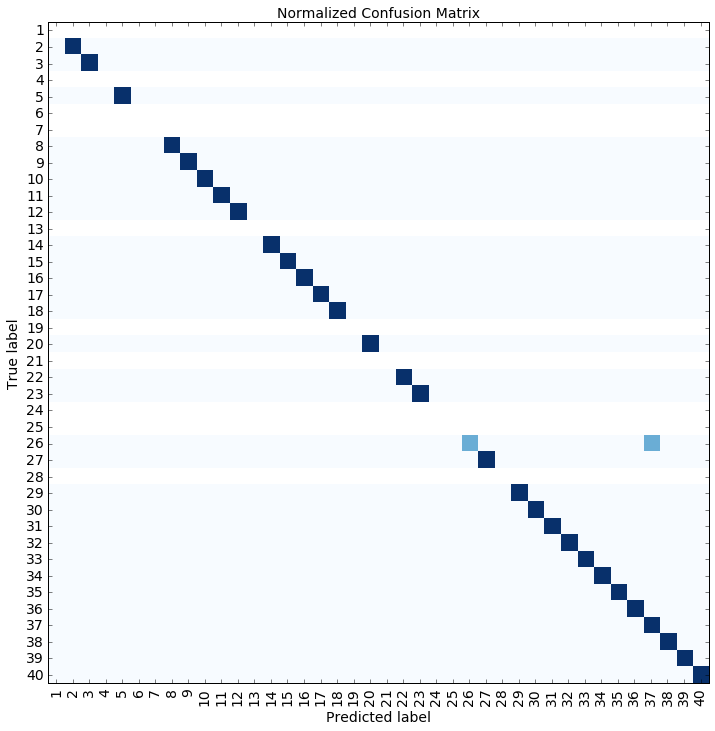

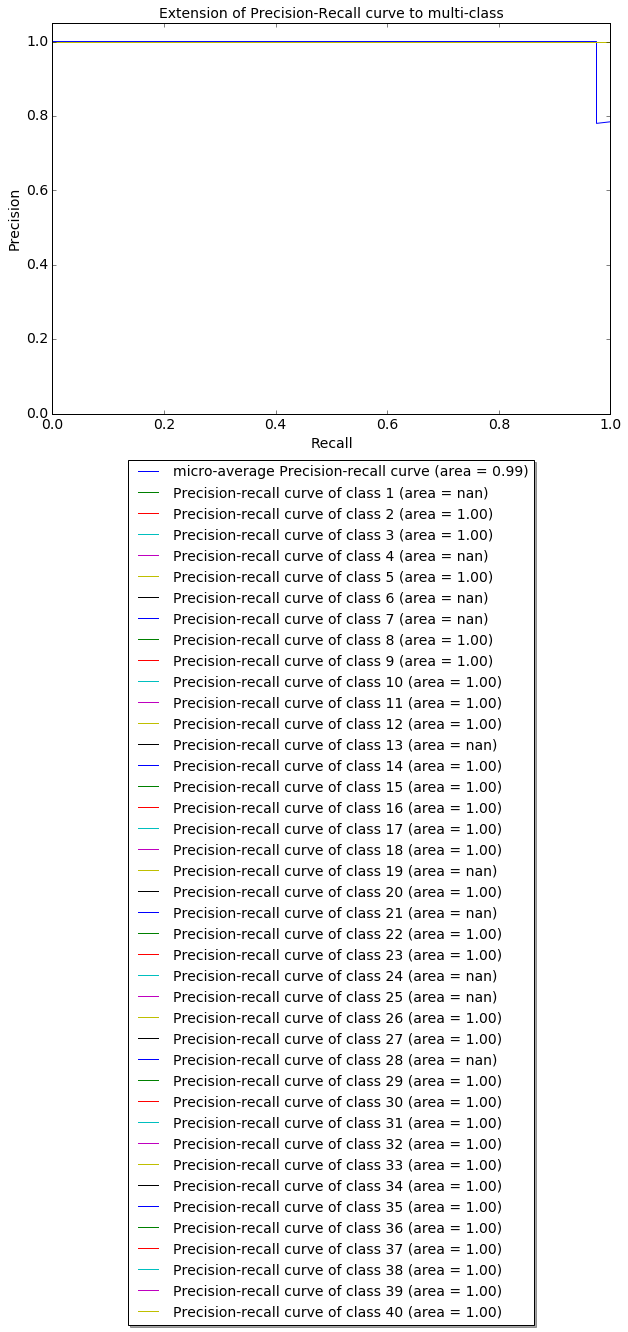

In [26]:
# Train test set with best parameter
clf = OneVsRestClassifier(SVC(
    kernel=kernel, gamma=best_parameter['gamma'], 
    C=best_parameter['C'], class_weight='balanced'
))
pca = PCA(X_CV, n_components=n_components)
pca_CV = pca.transform(X_CV)
pca_test = pca.transform(X_test)
clf.fit(pca_CV, y_CV)
y_pred = clf.predict(pca_test)
y_score = clf.decision_function(pca_test)
y_test_matrix = prepare_labels(y_test, orl.n_classes)

# Classfication report
report = ClassificationReport(y_test, y_pred)
print 'Average F1-score: %0.2f' % report.get_avg_f1_score()
print 'Accuracy: %0.2f%%' % (accuracy_score(y_test, y_pred)*100)
print 'Error rate: %0.2f%% (%s/%s)' % (
    (y_test != y_pred).sum()/float(len(y_pred)) * 100,
    (y_test != y_pred).sum(),
    len(y_pred)
)
print report.report

# Confusion matrix
plot.plot_normalized_confusion_matrix(
    y_test, y_pred, orl.n_classes, 
    range(1,orl.n_classes+1), figsize=(10,10)
)

# Precision recall curves for each class
plot.plot_precision_recall_curves(
    y_test, y_score, orl.n_classes, label_names=range(1,orl.n_classes+1)
)
plt.show()

# Train a Neural Network

In [32]:
# Splitting data set in training set and test set
#X_train, X_test, y_train, y_test = orl.create_train_test_split(test_size=0.25, to_file=False)
X_train, X_test, y_train, y_test = orl.load_train_test_split()
n_components = 75
pca = PCA(X_train, n_components=n_components)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test) 

# Layer's sizes
x_size = pca_train.shape[1]     # Number of input nodes
h_size = 120                    # Number of hidden nodes
y_size = orl.n_classes          # Number of outcomes
weights = float(orl.n_samples) / (orl.n_classes * bincount(y_train))
nn = NeuralNetwork(x_size, h_size, y_size, batch=20,
                   weighted=True, weights=weights)
results = nn.evaluate_learning_rate(
    pca_train, pca_test, y_train, y_test, 
    orl.n_classes, learning_rate=[1.0],
    stdout=False
)

Learning rate = 1.0, train accuracy = 76.67%, test accuracy = 75.00%, test f1 = 70.00%


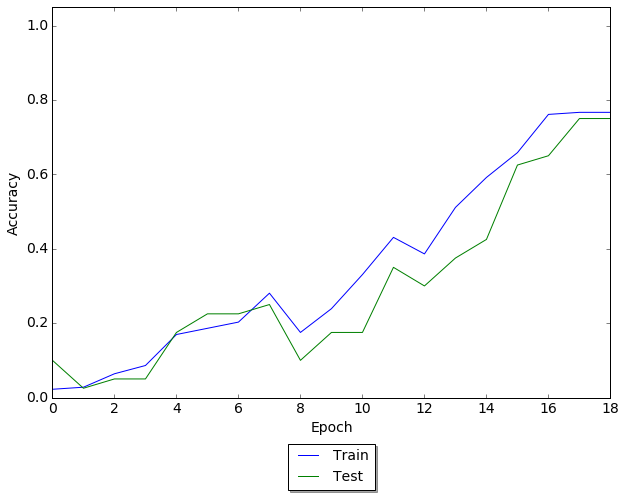

In [33]:
plot.plot_epochs(results['epoch'], results['train_accuracy'], results['test_accuracy'])